<h1 style="font-size:50px;">Intro to QRC python package</h1>

This notebook is meant as a tutorial for anyone who wants to be able to use the QRC package for reservoir computing. In this notebook you will find examples and instruction on how to use the different modules in QRC and how you can create your own quantum dot reservoir for reservoir computing. For more information about the background of quantum dot reservoir computing, information about how the system is solved and results, see QRC_project_notes.pdf. 

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('..\QRC')
sys.path.append('..\QRC\Timing_task')
sys.path.append('..\QRC\Task_engine')
sys.path.append('..\QRC\Reservoir_dynamics')

from Qreservoir import Qreservoir
from Qreadout import Qreadout
import Reservoir_dynamics
from Timing_task import Timing_task
from Task_runner import Task_runner

<h1 style="font-size: 36px;">Qreservoir</h1>

In `Qreservoir.py`, the quantum dot reservoir is created and simulated using the python package QMEQ. To create a `Qreservoir` object, the following parameters can be defined: 

- **`reservoir_input`**: `Callable[[float], float]`  The reservoir input as a function of time.
- **`t_range`**: `List[float]` The time range where the reservoir is used. In most cases, the reservoir is evaluated in the time range `[0, 1]` in this project.
- **`seed`**: `Optional[int] = None`  A seed to make the randomization deterministic.
- **`evolution_rate`**: `float = 1`  A scaling parameter of the Lindbladian, determining how fast the dynamics of the system are.
- **`internal_weight_factor_e`**: `float = 1`The weight determining the range in which the quantum dot (QD) energies are initialized.
- **`internal_weight_factor_c`**: `float = 1` The weight determining the range in which the QD Coulomb interactions are initialized.
- **`internal_weight_factor_o`**:  `float = 1`The weight determining the range in which the tunneling amplitudes between QDs are initialized.
- **`input_weight_factor`**:  `float = 1`The scale of the input weights connecting the input function and chemical potentials.

<h1 style="font-size: 24px;">Initialization and Functionality</h1>

After initializing the `Qreservoir` object, the output current from the reservoir can be calculated using the following methods:

- **`get_I_t()`**:  Calculates the output current over time.
- **`get_I_stat_t()`**:  Calculates the stationary for each timestep. 

Bellow is an example of creating a Qreservoir object and generating the current.

Time to solve ode:  0.5993180274963379
Number of iterations (nfev):  1352
Total time to solve system:  0.4265413284301758
Average time to solve system 0.00031548914824717144


Text(0.5, 0, 'Time')

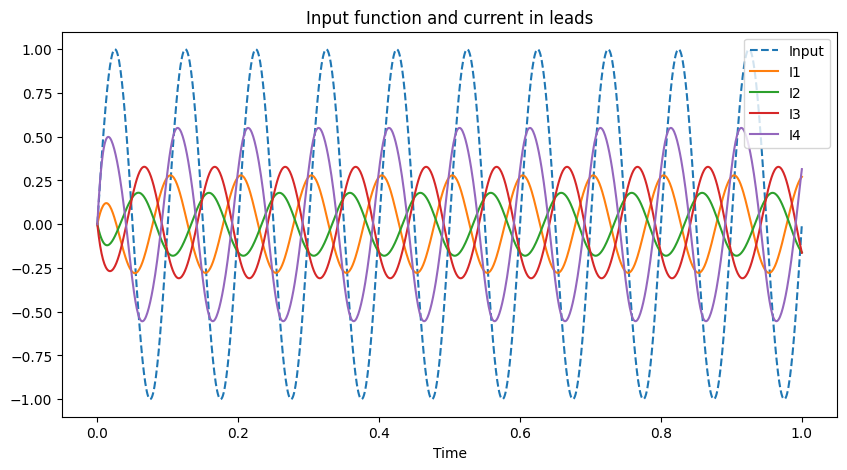

In [37]:
#Example of creating a Qreservoir and generating current: 

#Time range:
t0 = 0
t1 = 1
steps = 1000
t_range = np.linspace(t0, t1, steps)

#Input function:
def input_function(t):
    return np.sin(2*np.pi*t*10)

# Reservoir parameters:
reservoir_seed = 1
evolution_rate = 100

# Create reservoir:
reservoir = Qreservoir(t_range = t_range, reservoir_input = input_function, 
                       seed = reservoir_seed,evolution_rate = evolution_rate)

# Generate current 
I = reservoir.get_I_t()

# Plot input and current
I_scale = 5 # Multiply current to make it visible on the plot
plt.figure(figsize=(10, 5))
plt.plot(t_range, input_function(t_range), label = 'Input', linestyle = '--')
plt.plot(t_range, I*I_scale, label = 'Current')
plt.legend(['Input', 'I1', 'I2', 'I3', 'I4'])
plt.title('Input function and current in leads')
plt.xlabel('Time')

<h1 style="font-size: 36px;">Qreadout</h1>

The Qreadout file is responsible for training and testing the linear layer for some reservoir output and target data. There is one optional parameter determining the amout of regularization during training:

- **`regularization_term`**: `float = 1e-6` 

To train and test the network, the function **`get_predictions()`** is used, with the following parameters: 

- **`I_train`**: `np.ndarray`, Current from reservoir used for training
- **`target_train`**: `np.ndarray`, Target used for training
- **`I_test`**: `np.ndarray`, Current from reservoir used for testing
- **`warmup`**: `int = 100`, The amount of steps to use for warmup

Bellow is an example of how we can take output from the reservoir and train the readout layer for a prediction task. However, an easier way of doing this is to use the module `Task_engine`, described bellow in the section Task_engine

Running Ridge-4: 100%|██████████| 200/200 [00:00<00:00, 14907.52it/s]


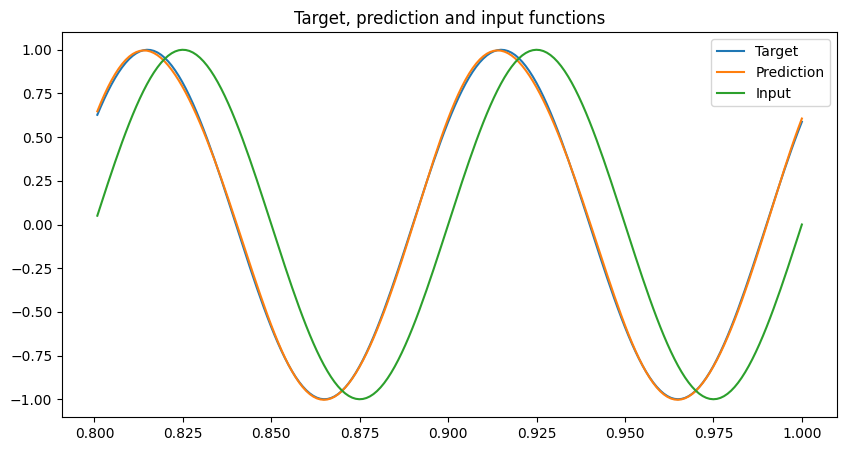

In [39]:
#Target function is the input function shifted by 0.01 seconds:
def target_function(t):
    return input_function(t+0.01)

#Generate target array:
target_array = target_function(t_range)

#Split target and current into training and testing sets:
training_fraction = 0.8 # Fraction of the data used for training
split_index = int(steps*training_fraction)
target_train = target_array[:split_index]
target_test = target_array[split_index:]
I_train = I[:split_index]
I_test = I[split_index:]

# Create Qreadout object:
readout = Qreadout()

# Train the readout and get predictions:
target_predictions = readout.get_predictions(I_train, target_train, I_test)

#Plot the results:
plt.figure(figsize=(10, 5))
plt.plot(t_range[split_index:], target_test, label = 'Target')
plt.plot(t_range[split_index:], target_predictions, label = 'Prediction')
plt.plot(t_range[split_index:], input_function(t_range[split_index:]), label = 'Input')
plt.title('Target, prediction and input functions')
plt.legend()

<h1 style="font-size: 36px;">Task engine</h1>

Task engine is a module to simplify the process of creating the reservoir, generating input and target functions and training the network. The module consists of three files: 

<h1 style="font-size: 24px;">Input_function.py</h1>

In the input function file, different common input functions are stored. One can fetch an input function with the function set_input_func() together with the specified input function name. The implemented input functions are currently: 

- `"Random_sin"` : A sum of random sine waves (sum of 1000 sine waves as default)
- `"Random_smooth"`: Randomized values with cubic interpolation 
- `"Random_white"`: Randomized hite noise
- `"Sin"`: A sine wave
- `"Sin_3"`: As sum of three sine waves
- `"Mackey_glass"`: Mackey Glass time series

One can add more input functions by adding a function for it and defining a name for it in set_input_func(). 

<h1 style="font-size: 24px;">Target_function.py</h1>

In the target function file, different tasks/targets are specified. The target functions can be fetched with the function set_target() with the parameters: 

- **`target_func_name`**: `str`, The target func name
- **`target_param`**: `Any`, A parameter for the target function
- **`t_range`**: `np.ndarray`, The time steps for the target function 
- **`input_func`**: `Callable[[float], float]`, The input function to the reservoir

Currently the following target functions are available: 
- `"Delay"` : A delay of the input function, the parameter is the number of delayed steps
- `"Narma-n"` : The Narma-n task, the parameter is the value of n
- `"Prediction"` : Prediction of the input function, the parameter is the number of prediction steps. 

To add a target, one can add a function for the target and specify the name in the set_target() function. 

<h1 style="font-size: 24px;">Task_runner.py</h1>
The Task_runner file, creates a reservoir and generates a current for the specified input function name. The task runner file can then be used for different task for the specified input.

To create a Task_runner object the following parameters can be specified: 

- **`input_func_name`**: `str`, Name of input function
- **`evolution_rate`**: `float`, Rescaling parameter of the Lindbladian
- **`reservoir_seed`**: `Optional[int] = None`, Seed to make the randomization of the reservoir deterministic
- **`input_func_seed`**: `Optional[int] = None`, Seed to make the randomization of the input function deterministic
- **`V`**: `int = 1`, Value used for time multiplexing, sets how many times the current is sampled for each time step
- **`steps`**: `int = 1000`, Number of timesteps 
- **`internal_weight_factor_e`**: `float = 1`  The weight determining the range in which the QD energies are initialized.
- **`internal_weight_factor_c`**: `float = 1` The weight determining the range in which the QD Coulomb interactions are initialized.
- **`internal_weight_factor_o`**:  `float = 1` The weight determining the range in which the tunneling amplitudes between QDs are initialized.
- **`input_weight_factor`**:  `float = 1` The scale of the input weights connecting the input function and chemical potentials.
- **`training_split`**: `float = 2 / 3`, The fraction of the total target data that is used for training (and warmup)
- **`regularization_term`**: `float = 1e-6`, The regularization term used during training

To test the reservoir defined in Task_runner, the function **`run_test()`** can be used with the following parameters: 


- **`target_func_name`**: `str`, The name of the target function
- **`target_param`**: `Optional[Any] = None`, Parameter for the target function
- **`warmup`**: `Optional[int] = None`, The number of steps used for warmup

**`run_test()`** returns the performance measured in memory accuracy and mean squared error, the predictions of the network and the target. 

Bellow is an example of using the Task engine module for the Narma-n task with Random_sin as input function:

Time to solve ode:  1.4124722480773926
Number of iterations (nfev):  2267
Total time to solve system:  0.7969369888305664
Average time to solve system 0.0003515381512265401


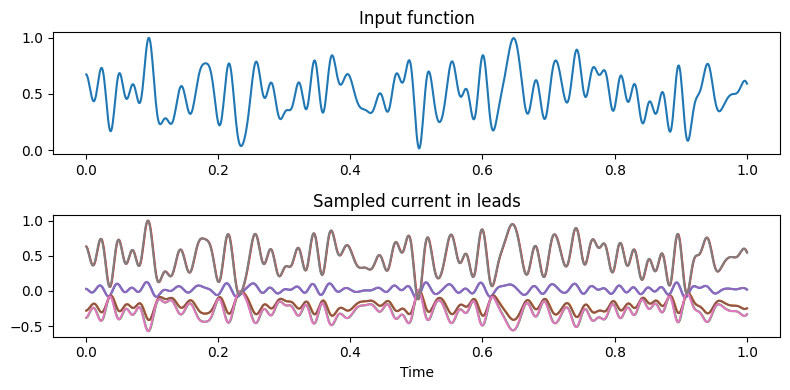

In [76]:
#Initialize task runner object
input_function = 'Random_sin'
evolution_rate = 300
V = 2
task_runner = Task_runner(input_function, evolution_rate, V =V)

#Visualize the input and current:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(task_runner.t_range, task_runner.input_func(task_runner.t_range), label='Input')
ax[0].set_title('Input function')
ax[1].plot(task_runner.t_range, task_runner.I)
ax[1].set_title('Sampled current in leads')
ax[1].set_xlabel('Time')
fig.tight_layout()
plt.show()

Running Ridge-26: 100%|██████████| 333/333 [00:00<00:00, 20576.97it/s]


matrix: [[0.11024012 0.10836914]
 [0.10836914 0.10951857]]
Memory accuracy: 0.9727110802970315


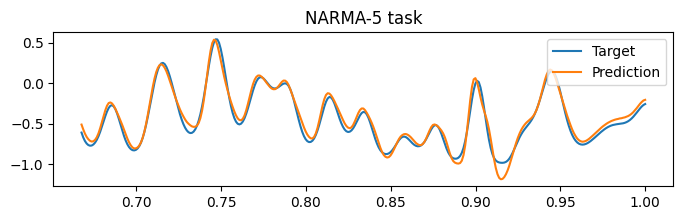

In [82]:
#Run NARMA-5 task: 
target_function = 'Narma'
n = 5
memory_accuracy, nmse, predictions, target = task_runner.run_test(target_function, n)

#Plot the results:
t_test_range = task_runner.t_test # Time range for the test set
plt.figure(figsize=(8, 2))
plt.plot(t_test_range, target, label = 'Target')
plt.plot(t_test_range, predictions, label = 'Prediction')
plt.title('NARMA-5 task')
plt.legend(loc = 'upper right')
print('Memory accuracy:', memory_accuracy)

Running Ridge-29: 100%|██████████| 333/333 [00:00<00:00, 29655.26it/s]


matrix: [[0.0919945  0.08967761]
 [0.08967761 0.09052753]]


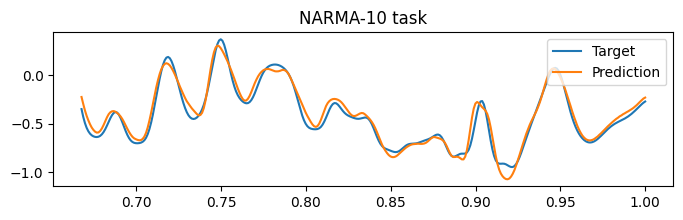

Memory accuracy: 0.9656629701982387


In [87]:
#Run NARMA-10 task: 
target_function = 'Narma'
n = 10
memory_accuracy, nmse, predictions, target = task_runner.run_test(target_function, n)

#Plot the results:
t_test_range = task_runner.t_test # Time range for the test set
plt.figure(figsize=(8, 2))
plt.plot(t_test_range, target, label = 'Target')
plt.plot(t_test_range, predictions, label = 'Prediction')
plt.title('NARMA-10 task')
plt.legend(loc = 'upper right')
plt.show()
print('Memory accuracy:', memory_accuracy)

<h1 style="font-size: 36px;">Timing Task</h1>

The Timing task is a module implemented specifically for the the timing task. The timing task is not implemented in Task_engine, because the same data is used for training and testing is the timing task, making it different from the other tasks, where data is split into training and test.

In the timing task a step input is fed into the reservoir and the task is to output a peak a specific time after the step. When initializing a Timing_task object the following parameters can be specified:  

- **`evolution_rate`**: `float`, Rescaling parameter of the Lindbladian
- **`steps`**: `int = 1000`Number of time steps 
- **`reservoir_seed`**: `Optional[int] = None`  Seed to make the randomization of the reservoir deterministic
- **`internal_weight_factor_e`**: `float = 1`  The weight determining the range in which the QD energies are initialized.
- **`internal_weight_factor_c`**: `float = 1` The weight determining the range in which the QD Coulomb interactions are initialized.
- **`internal_weight_factor_o`**:  `float = 1` The weight determining the range in which the tunneling amplitudes between QDs are initialized.
- **`input_weight_factor`**:  `float = 1` The scale of the input weights connecting the input function and chemical potentials.

To perform the timing task, the function **`run_test()`** can be used with the parameters: 
- **`timer`**: `int` The timer of the timing task
- **`warmup`**: `Optional[int] = None`  Number of steps used for warmup

Here is an example of the timing task: 

Time to solve ode:  0.22378182411193848
Number of iterations (nfev):  719
Total time to solve system:  0.14783573150634766
Average time to solve system 0.0002056129784511094


Running Ridge-46: 100%|██████████| 1000/1000 [00:00<00:00, 76588.71it/s]


Memory accuracy: 0.7
Mean squared error: 0.0


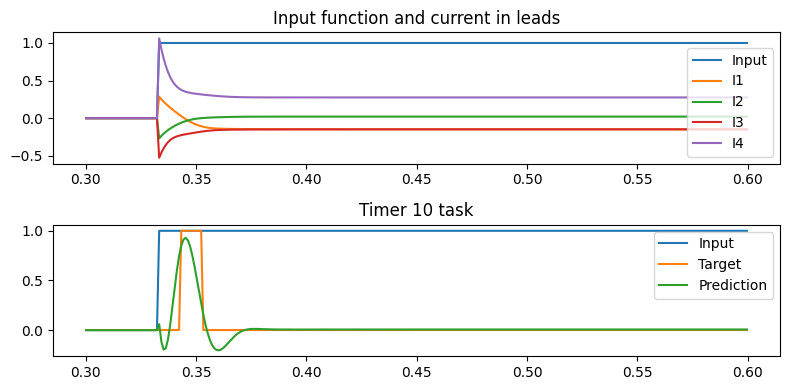

In [104]:
#Create Timing_task object:
evolution_rate = 150
reservoir_seed = 1
timing_task = Timing_task(evolution_rate = evolution_rate, reservoir_seed = reservoir_seed)

#Runimer 10 task
timer = 10
ma, mse, predictions, target = timing_task.run_test(timer)

#Plot results
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
t_start, t_end = 300, 600 #Range of time to visualize
I_scaling = 5 # Scale current to make it visible in plots
t_range_plot = timing_task.t_range[t_start:t_end]
ax[0].plot(t_range_plot, timing_task.input_func(t_range_plot), label='Input')
ax[0].plot(t_range_plot, timing_task.I[t_start:t_end]*I_scaling)
ax[0].set_title('Input function and current in leads')
ax[0].legend(['Input', 'I1', 'I2', 'I3', 'I4'])

ax[1].plot(t_range_plot, timing_task.input_func(t_range_plot), label='Input')
ax[1].plot(t_range_plot, target[t_start:t_end], label = 'Target')
ax[1].plot(t_range_plot, predictions[t_start:t_end], label = 'Prediction')
ax[1].set_title(f'Timer {timer} task')
ax[1].legend(loc = 'upper right')
fig.tight_layout()

print('Memory accuracy:', np.round(ma,2))
print('Mean squared error:', np.round(mse,2))

<h1 style="font-size: 36px;">Reservoir Dynamics</h1>

Reservoir_dynamics.py contains functions to help with visualization and calculation of properties of the reservoir. Bellow are a few examples of functions that can be used:  

In [2]:
# First create a reservoir with a sine input function using task_engine
input_function = 'Sin'
evolution_rate = 100
task_runner = Task_runner(input_function, evolution_rate)
reservoir = task_runner.reservoir

Time to solve ode:  0.3203403949737549
Number of iterations (nfev):  1199
Total time to solve system:  0.22358274459838867
Average time to solve system 0.00018647434912292632


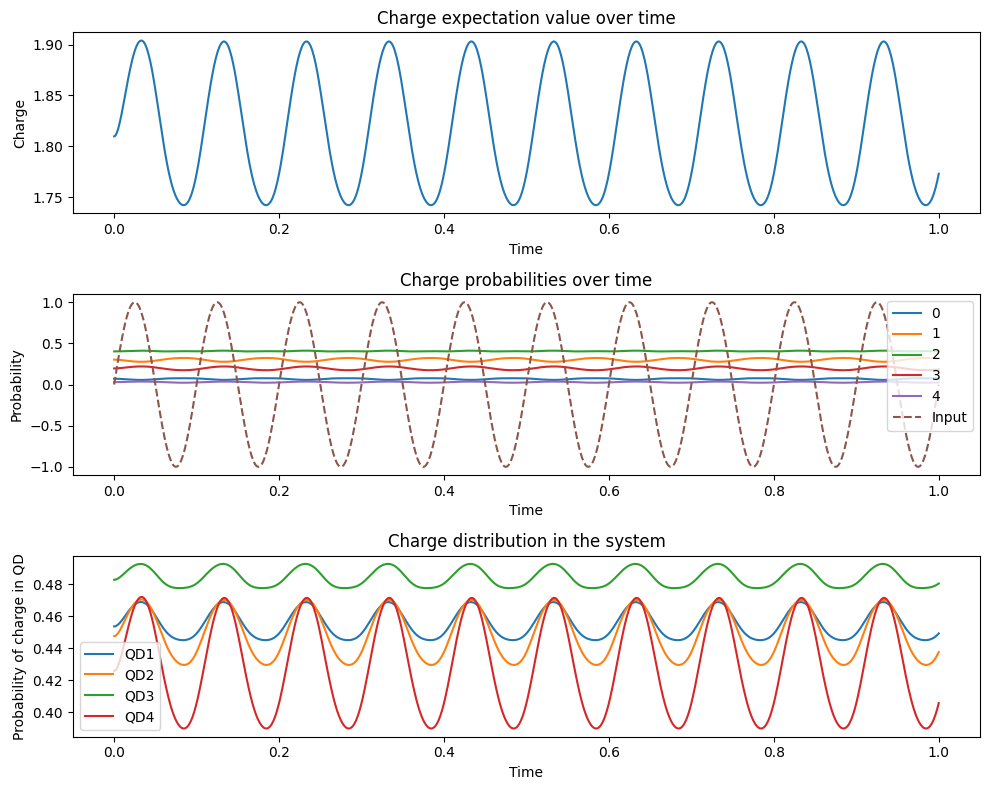

In [3]:
#Visualize information about charge in system
Reservoir_dynamics.plot_charge_prob(reservoir)

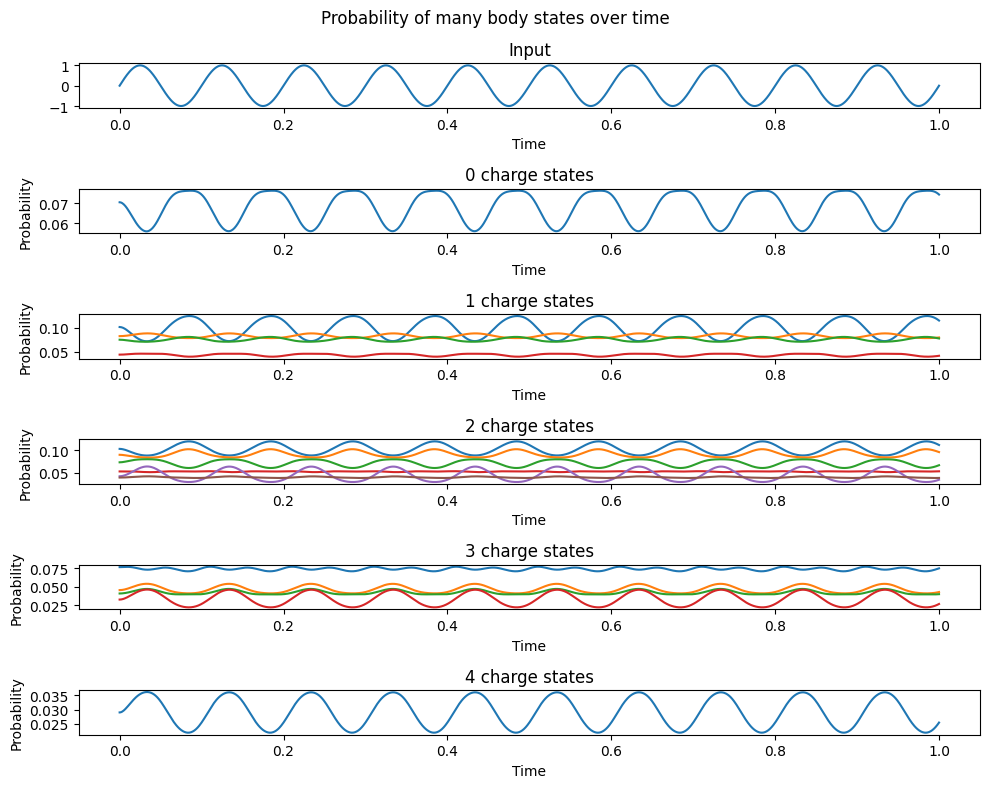

In [4]:
#Plot the probability of many body states (diagonal components of the density matrix) over time:
Reservoir_dynamics.plot_states_prob(reservoir)